# Instalar dependendias

In [1]:
!pip install sklearn

# Instalar Theano

In [2]:
!pip install --upgrade --no-deps theano

# Instalar Tensorflow y Keras


In [3]:
!pip install keras
!pip install tensorflow

# SOM


# Cómo importar las librerías


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importar el data set


In [5]:
dataset = pd.read_csv('./Credit_Card_Applications.csv')
# Nos quedamos con todas las columnas salvo la última, que es la clase (no la vamos a usar ya que usaremos un algoritmo no supervisado).
X = dataset.iloc[:, :-1].values
# Nos quedamos con la última columna. La usaremos solo para validar. 
y = dataset.iloc[:, -1].values

# Escalado de características

In [6]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)

# Entrenar el SOM

In [7]:
from minisom import MiniSom
# x e y: son el tamaño de la cuadrícula en horizontal y vertical. Queremos que los outliers destaquen por lo tanto no lo queremos muy grande. No tenemos muchísimos datos
#        por lo que no tiene sentido un mapa muy grande.
# input_len: cuantas dimensiones tiene nuestro espacio vectorial de entrada. Tenemos 15 columnas: el id del cliente y 14 atributos. Realmente no necesitamos el id del cliente
#            pero lo necesitaremos luego para saber de qué cliente se trata el outlier.
# sigma: es el radio inicial que se utiliza para establecer los vecinos de cada nodo potencial. Se irá actualizando dentro del algoritmo.
# learning_rate: capacidad de ir adaptando los valores de los pesos de una iteración a la siguiente. A mayor ratio de aprendizaje más rápida es la convergencia pero si es muy alto
#                podemos "pasarnos de frenada".
# decay_function: función que se puede utilizar para mejorar la convergencia.
# random_seed: para la reproducibilidad.
som = MiniSom(x = 10, y = 10, input_len = 15, sigma = 1.0, learning_rate = 0.5)
# Inicializamos los pesos de forma aleatoria.
som.random_weights_init(X)
# Entrena el dataset.
som.train_random(data = X, num_iteration = 100)

# Visualizar los resultados


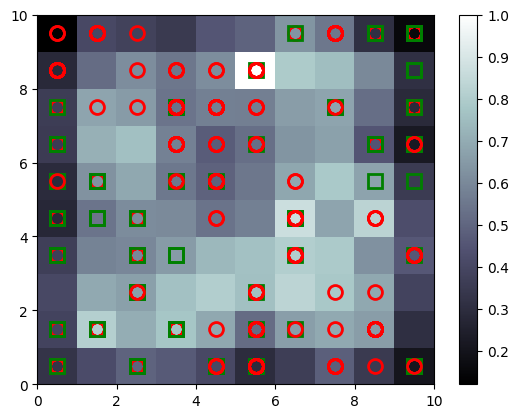

In [8]:
# Librería con funciones para pintar
from pylab import bone, pcolor, colorbar, plot, show
# Cambiamos el color del mapa de color
bone()
# Hacemos un rango de colores a partir del mapa de distancias que el SOM ha calculado, en formato matricial. 
# La matriz nos viene girada en cuanto a como la queremos.
pcolor(som.distance_map().T)
# Sacamos una barra de color: los valores más claros son los correspondientes a los MIDs más altos (aquellos con vecinos más alejados). Los valores más compactos son 
# los cuadrados con los valores más oscuros. Los blancos serán valores atípicos potenciales.
colorbar()
# Cuadrados verdes y círculos rojos para clientes que han obtenido aprobación o no.
markers = ['o', 's']
colors = ['r', 'g']
# Recorremos las observaciones:
for i, x in enumerate(X):
    # Obtenemos el nodo ganador para la observación.
    w = som.winner(x)
    # Pintamos el cuadrado o el círculo en las coordenadas del nodo ganador. Nos devuelven las coordenadas de la esquina inferior izquierda del cuadrado.
    # Como el marcador lo queremos ubicar en el medio y cada cuadrado es de tamaño 1x1 (recordemos que la cuadrícula completa es de 10x10) le sumamos 0.5 a las coordenadas.
    # En y tenemos un 1 si obtuvo aprobación y 0 si no. Sacamos de los marcadores y color el marcador y color correspondiente, por eso se ordenador así: en la 0 círculo rojo, en la 1 cuadrado verde.
    plot(w[0]+0.5, w[1]+0.5,
         markers[y[i]], markeredgecolor = colors[y[i]], markerfacecolor = 'None', 
         markersize = 10, markeredgewidth = 2)
show()

# En teoría debe de haber más círculos rojos cerca de los colores blancos y más cuadrados verdes cerca de los colores oscuros.

# Encontrar los fraudes

In [79]:
def find_frauds(som, X):
  # minisom ofrece un diccionario con todas las asignaciones diferentes de cada nodo ganador y los clientes asignados a él
  mappings = som.win_map(X)
  # Vamos a obtener los datos de clientes que están en el cuadrado blanco (máxima distancia media entre neuronas)
  # Vamos a encontrar los 2 máximos de la matriz de distancias
  # Por como recorreremos la matriz aquí no la transponemos
  distances = som.distance_map()
  maxTuples = np.array([(np.NaN, np.NaN, -np.Infinity), (np.NaN, np.NaN, -np.Infinity)])
  for i in range(distances.shape[0]):
    for j in range(distances.shape[1]):
      distance = distances[i][j]
      # Obtenemos el mínimo de los máximos encontrados hasta ahora y su índice
      k = np.argmin(maxTuples[:, 2])
      minMaxDistance = maxTuples[k]
      # Si la distancia es mayor al mínimo encontrado entonces sustituiremos ese mínimo con la nueva distancia
      if (distance > minMaxDistance[2]):
        maxTuples[k] = [i, j, distance]

  # Construimos un objeto de índice con las coordenadas de los máximos obtenidos anteriormente. Convertiremos a tupla esas coordenadas
  mappings_i = map(tuple, maxTuples[:, :-1])
  # Traemos los valores del diccionario de mappings a una lista
  mappings_list = [mappings.get(key) for key in mappings_i if mappings.get(key) != None]
  # Los concatenamos con numpy, en el eje 0 (ampliamos el array, los juntamos por fila)
  frauds = np.concatenate(mappings_list, axis = 0)
  return frauds


frauds = find_frauds(som, X)
# Aplicamos la desnormalización
frauds = sc.inverse_transform(frauds)


# # Esta es la forma del ejemplo
# mappings = som.win_map(X)
# # Esta línea se corresponde al ejemplo del curso...pero nuestro nodo blanco está en otro sitio. En el ejemplo concatena dos cuadrados
# # Ojo que estas coordenadas cambiarán por ejecución...no tiene mucho sentido este método.
# # Los concatenamos con numpy, en el eje 0 (ampliamos el array, los juntamos por fila)
# # Aplicamos la desnormalización
# frauds = np.concatenate( (mappings[(6,1)], mappings[(7,8)]), axis = 0 )
# frauds = sc.inverse_transform(frauds)